In [1]:
import math
import random
import numpy as np

In [2]:
%load_ext cython

In [3]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False) 

def _nn_search_cython(int q, np.ndarray[list, ndim = 1] d, int N):
    """
    find the nn set for ponit q
    """
    cdef np.ndarray P
    cdef int m, i
    
    m = d.shape[0]
    P = np.ndarray([q])
    for i in xrange(m):
        if q in d[i]:
            P = np.append(P, d[i])
                
    P = np.unique(P.astype(int))
    P = np.delete(P,np.where(P==q))
    P = np.delete(P,np.where(P<0))
    P = np.delete(P,np.where(P>N))
    return P

def nn_search_cython(q, d,N):
    return _nn_search_cython(q, d, N)

In [4]:
import numba
from numba import jit
from functools import reduce

In [7]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

In [8]:
def get_input(x):
    temp = []
    for i,v in enumerate(x):
        temp.append([v,i])
    return temp

def chainHash(InputList, Leafs):
    res = {}
    for tup in InputList:
        if tup[0] not in res:
            temp = []
            temp.append(tup[1])
            res["%s" % tup[0]] = temp
        else:
            parent = list(map(lambda s: find_parentid(Leafs[s]), res["%s" % tup[0]]))
            if (find_parentid(Leafs[tup[1]]) not in parent) | (Leafs[tup[1]].parent is None):
                res["%s" % tup[0]].append(tup[1])
    return res

def find_parentid(Node):
    temp = None
    if Node.parent is not None:
        temp = find_parentid(Node.parent)
    else:
        temp = Node.id
    if temp>=0:
        return None
    else:
        return temp

def find_parentNode(Node):
    if Node.parent is not None:
        return find_parentNode(Node.parent)
    else:
        return Node

def euler_distance(point1, point2):
    """
    imput: point1, point2: list
    output: float
    """
    return np.linalg.norm(point1 - point2)


def flatten(xs, acc=[]):
    """Blah"""
    return list(reduce(lambda x,y: x+y,xs))

@dv.parallel(block = True)
def change_unary2(x):
    temp = ''
    for num in x:
        tem = int(11 - num)
        temp += ("1"*(11-tem)+ "0"*tem)
    return temp

In [9]:
class Nodes(object):
    def __init__(self,id):
        """
        :param parient
        :param children
        :param id
        """
        self.parent = None
        self.children = []
        self.id = id
    def add_leaf(self, leaf):
        if leaf not in self.children:
            self.children.append(leaf)
    def set_parent(self, node):
        if self.parent is not None:
            pass
        else:
            self.parent = node
    def show_childrenid(self):
        temp = []
        for child in self.children:
            temp.append(child.id)
        return temp
    def display(self,depth):
        print ('-'*depth + "  " +str(self.id))
        for child in self.children:
            child.display(depth+2)
    
class Leafs(Nodes):
    def __init__(self,id, vec):
        """
        :param vec
        :param parient
        :param children
        :param id
        """
        self.vec = vec
        self.parent = None
        self.children = []
        self.id = id
    def add_leaf(self,leaf):
        raise Exception("Leaf nodes can't insert catalog")
    def set_parent(self, node):
        if self.parent is not None:
            raise Exception("It has a parent already")
        else:
            self.parent = node

In [10]:
class LSH(object):
    def __init__(self, k, l, C, d):
        """
        k: number of sampled bits
        l: number of hash functions
        C: a constant
        d: number of attributes

        """
        assert l > 0
        assert k > 0
        self.k = k
        self.l = l
        self.C = C
        self.d = d
        self.I = []
    def creat_I(self):
        """
        create l distinct hash functions
        """
        while (len(self.I) < self.l):
            temp = sorted(random.sample(range(self.C*self.d),self.k))
            if temp not in self.I:
                self.I.append(temp)
                
    @dv.parallel(block = True)
    def change_unary(self, x):
        """
        change the list into unary expression
        x: list[1*d]
        """
        temp = ''
        for num in x:
            tem = int(self.C - num)
            temp += ("1"*(self.C-tem)+ "0"*tem)
        return temp
    
    def get_h_value(self, v, fun_I):
        temp = np.array(list(v))
        return ''.join(temp[fun_I])
    def hash_table(self,data): 
        """
        each row shows one hash function
        """
        m,n = np.shape(data)
        h_table = []
        v_table = np.array(change_unary2.map(data))
        self.creat_I()
        for fun_I in self.I:
            temp = list(map(lambda s: self.get_h_value(s, fun_I), v_table))
            h_table.append(temp)
        return np.array(h_table)
    def get_buckets(self,Leafs,h_table):
        r = list(map(lambda s: chainHash(get_input(s), Leafs),h_table))
        return r

In [24]:
class Hierarchical(object):
    def __init__(self):
        self.labels = None
        self.Nodes = []
        self.point_num = 0
    def merge_nodes(self, node1, node2):
        newid = -len(self.Nodes)-1
        flag = 0
        if (node1.parent is not None) & (node2.parent is not None):
            if find_parentid(node1) == find_parentid(node2):
                flag = 1
            else:
                NewNode = Nodes(id = newid)
                NewNode.add_leaf(find_parentNode(node1))
                NewNode.add_leaf(find_parentNode(node2))
                find_parentNode(node1).set_parent(NewNode)
                find_parentNode(node2).set_parent(NewNode)
                self.Nodes.append(NewNode)
        if (node1.parent is not None) & (node2.parent is None):
            newid = find_parentid(node1)
            self.Nodes[np.abs(newid)-1].add_leaf(node2)
            node2.set_parent(self.Nodes[np.abs(newid)-1])
        if (node1.parent is None) & (node2.parent is not None):
            newid = find_parentid(node2)
            self.Nodes[np.abs(newid)-1].add_leaf(node1)
            node1.set_parent(self.Nodes[np.abs(newid)-1])
        if (node1.parent is None) & (node2.parent is None):
            NewNode = Nodes(id = newid)
            NewNode.add_leaf(node1)
            NewNode.add_leaf(node2)
            node1.set_parent(NewNode)
            node2.set_parent(NewNode)
            self.Nodes.append(NewNode)
        return flag
             
    def fit(self, x, R, A, C,l):
        """
        x:raw data, m*n
        R: minimun distance
        A: the ratio to increase R
        l: number of hash functions
        C: a constant
        """
        leafs = [Leafs(vec=v, id=i) for i,v in enumerate(x)]
        distances = {}
        self.point_num, future_num = np.shape(x)  
        self.labels = [ -1 ] * self.point_num
        currentNo = self.point_num
        i = 1
        while (currentNo > 1) & (R < 20):
            #k = int(future_num * C * np.sqrt(future_num)/(2 * R))+3
            k = 10
            ls = LSH(k,l ,C ,d = future_num)
            h_table = ls.hash_table(x)
            r = ls.get_buckets(leafs, h_table)
            w = np.array(flatten(list(map(lambda s: list(s.values()),r))))
            for p in range(self.point_num):
                P = nn_search_cython(p, w, self.point_num+1).astype(int)
                for q in P:
                    d_key = (p, q)
                    if d_key not in distances:
                        distances[d_key] = euler_distance(leafs[p].vec, leafs[q].vec)
                    d = distances[d_key]
                    if i <= 1:
                        if d <= R:
                            flag = self.merge_nodes(leafs[p], leafs[q])
                            if flag == 0:
                                currentNo -= 1
                    else:
                        if (d <= R) & (d > R/A):
                            flag = self.merge_nodes(leafs[p], leafs[q])
                            if flag == 0:
                                currentNo -= 1
            i += 1
            R = R*A
        for i in range(self.point_num):
            self.labels[i] = find_parentid(leafs[i])

    def display_depth(self, depth):
        self.Nodes[-1].display(depth)


### Comparison

We will compare LSH-link with single linkage clustering and DBSCAN, an algorithm that uses a density-based approach to find neighbors. All three algorithms are applied to the first simulated dataset. 

In [25]:
x0 = 3 + np.random.normal(loc=0, scale=1, size = (200,))
y0 = 15 + np.random.normal(loc=0, scale=1, size = (200,))

x1 = np.linspace(4, 8, num = 100) 
x1_coord = np.linspace(4, 8, num = 100) 
y1 = 8 + np.sqrt(4 - (x1_coord - 6)**2)
y1_coord = y1
y2_coord = 8 - np.sqrt(4 - (x1_coord - 6)**2)
x2 = np.r_[x1_coord, x1_coord].reshape(200,) + np.random.normal(loc=0, scale=0.2, size = (200,))
y2 = np.r_[y1_coord, y2_coord].reshape(200,) + np.random.normal(loc=0, scale=0.2, size = (200,))

x3 = 10 + np.random.normal(loc=0, scale=5, size = (200,))
y3 = 4 + np.random.normal(loc=0, scale=0.3, size = (200,))

x4 = 18 + np.random.normal(loc=0, scale=0.2, size = (200,))
y4 = 10 + np.random.normal(loc=0, scale=3, size = (200,))

x5 = 8 + np.random.normal(loc=0, scale=0.2, size = (200,))
y5 = 15 + np.random.normal(loc=0, scale=0.2, size = (200,))

x6 = 15 + np.random.normal(loc=0, scale=0.2, size = (200,))
y6 = 12 + np.random.normal(loc=0, scale=2.5, size = (200,))

x7 = 6 + np.random.normal(loc=0, scale=0.1, size = (200,))
y7 = 8 + np.random.normal(loc=0, scale=0.1, size = (200,))

xs = np.r_[x0, x1, x2, x3, x4, x5, x6, x7]
ys = np.r_[y0, y1, y2, y3, y4, y5, y6, y7]

In [26]:
data = []
for i,v in zip(xs,ys):
    data.append(np.array([i,v]))

In [27]:
import pandas as pd
data = pd.DataFrame(data)
data = (data - data.min())/(data.max() - data.min())
test2 = data.values
test2 = test2 * 10

In [28]:
%%time
lsh = Hierarchical()
lsh.fit(test2, R =0.8, A =1.5, C = 11, l = 30)

CPU times: user 16.4 s, sys: 692 ms, total: 17.1 s
Wall time: 17.2 s


#### Single Linkage Clustering

The following code for single linkage algorithm originates from the following link : 

https://zhuanlan.zhihu.com/p/32438294

In [29]:
import math
import numpy as np
from sklearn import datasets
from sklearn import cluster

def euler_distance(point1, point2):
    """
    imput: point1, point2: list
    output: float
    """
    distance = 0.0
    for a, b in zip(point1, point2):
        distance += math.pow(a - b, 2)
    return math.sqrt(distance)

class ClusterNode(object):
    def __init__(self, vec, left=None, right=None, distance=-1, id=None, count=1):
        """
        :param vec
        :param left
        :param right
        :param distance
        :param id
        :param count
        """
        self.vec = vec
        self.left = left
        self.right = right
        self.distance = distance
        self.id = id
        self.count = count

class Hierarchical(object):
    def __init__(self, k = 1):
        assert k > 0
        self.k = k
        self.labels = None
    def fit(self, x):
        nodes = [ClusterNode(vec=v, id=i) for i,v in enumerate(x)]
        distances = {}
        point_num, future_num = np.shape(x)  
        self.labels = [ -1 ] * point_num
        currentclustid = -1
        while len(nodes) > self.k:
            min_dist = math.inf
            nodes_len = len(nodes)
            closest_part = None  
            for i in range(nodes_len - 1):
                for j in range(i + 1, nodes_len):
                    d_key = (nodes[i].id, nodes[j].id)
                    if d_key not in distances:
                        distances[d_key] = euler_distance(nodes[i].vec, nodes[j].vec)
                    d = distances[d_key]
                    if d < min_dist:
                        min_dist = d
                        closest_part = (i, j)
            part1, part2 = closest_part
            node1, node2 = nodes[part1], nodes[part2]
            new_vec = [ (node1.vec[i] * node1.count + node2.vec[i] * node2.count ) / (node1.count + node2.count)
                        for i in range(future_num)]
            new_node = ClusterNode(vec=new_vec,
                                   left=node1,
                                   right=node2,
                                   distance=min_dist,
                                   id=currentclustid,
                                   count=node1.count + node2.count)
            currentclustid -= 1
            del nodes[part2], nodes[part1]   
            nodes.append(new_node)
        self.nodes = nodes
        self.calc_label()

    def calc_label(self):
        for i, node in enumerate(self.nodes):
            self.leaf_traversal(node, i)

    def leaf_traversal(self, node: ClusterNode, label):
        if node.left == None and node.right == None:
            self.labels[node.id] = label
        if node.left:
            self.leaf_traversal(node.left, label)
        if node.right:
            self.leaf_traversal(node.right, label)

In [32]:
%%time
slink = Hierarchical(7)
slink.fit(test2)

CPU times: user 6min 33s, sys: 800 ms, total: 6min 34s
Wall time: 6min 37s


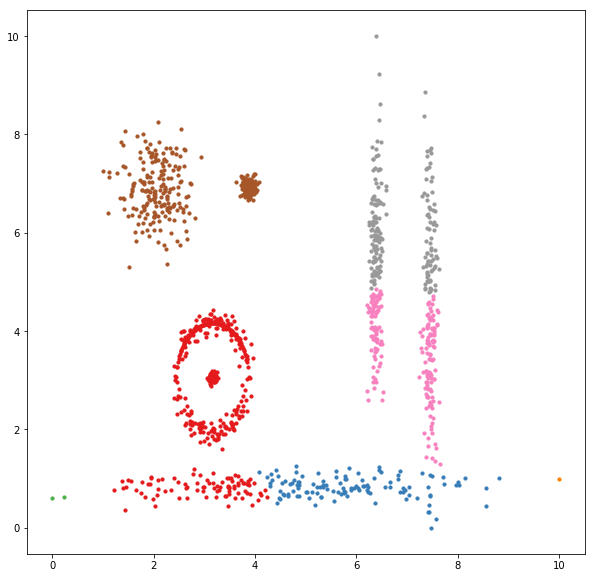

In [33]:
sl_labels = np.array(slink.labels)

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

plt.figure(figsize=(10,10))
plt.scatter(test2[sl_labels==0,0], test2[sl_labels==0,1], s=10, color=colors[1])
plt.scatter(test2[sl_labels==1,0], test2[sl_labels==1,1], s=10, color=colors[2])
plt.scatter(test2[sl_labels==2,0], test2[sl_labels==2,1], s=10, color=colors[3])
plt.scatter(test2[sl_labels==3,0], test2[sl_labels==3,1], s=10, color=colors[4])
plt.scatter(test2[sl_labels==4,0], test2[sl_labels==4,1], s=10, color=colors[6])
plt.scatter(test2[sl_labels==5,0], test2[sl_labels==5,1], s=10, color=colors[0])
plt.scatter(test2[sl_labels==6,0], test2[sl_labels==6,1], s=10, color=colors[7])
pass

#### DBSCAN

We compare LSH-link with DBSCAN (Density-Based Spatial Clustering of Applications with Noise) with $\epsilon$ (parameter for DBSCAN) $= R = 0.8$ 

In [47]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [48]:
%time db = DBSCAN(eps=0.8, min_samples=10).fit(test2)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 17.1 ms


In [49]:
import matplotlib.pyplot as plt

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

unique_labels = set(labels)

unique_labels

{-1, 0, 1, 2}

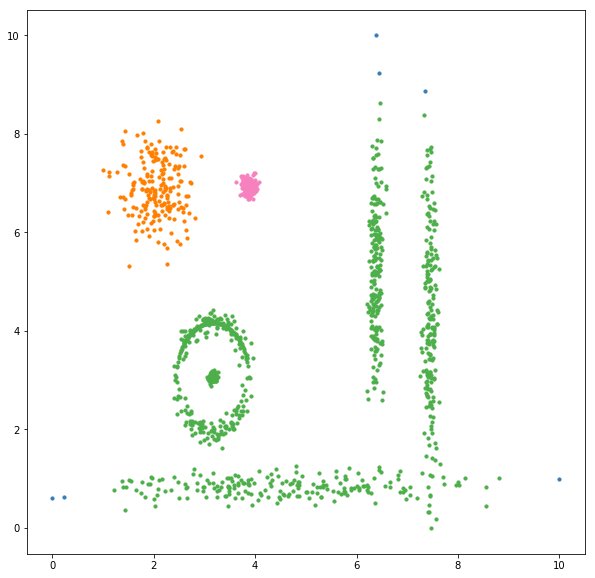

In [50]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

plt.figure(figsize=(10,10))
plt.scatter(test2[labels==-1,0], test2[labels==-1,1], s=10, color=colors[0])
plt.scatter(test2[labels==0,0], test2[labels==0,1], s=10, color=colors[1])
plt.scatter(test2[labels==1,0], test2[labels==1,1], s=10, color=colors[2])
plt.scatter(test2[labels==2,0], test2[labels==2,1], s=10, color=colors[3])
pass